In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

from reader import Reader


DATASET_NAME = 'snips' # change between 'atis' and 'snips'
reader = Reader(dataset=DATASET_NAME)
df = reader.construct_df_from_dataset(mode='train')
df.head()

,utterance,slots,intent
0,"[listen, to, westbam, alumb, allergic, on, goo...","[O, O, B-artist, O, B-album, O, B-service, I-s...",PlayMusic
1,"[add, step, to, me, to, the, 50, clásicos, pla...","[O, B-entity_name, I-entity_name, I-entity_nam...",AddToPlaylist
2,"[i, give, this, current, textbook, a, rating, ...","[O, O, O, B-object_select, B-object_type, O, O...",RateBook
3,"[play, the, song, little, robin, redbreast]","[O, O, B-music_item, B-track, I-track, I-track]",PlayMusic
4,"[please, add, iris, dement, to, my, playlist, ...","[O, O, B-artist, I-artist, O, B-playlist_owner...",AddToPlaylist


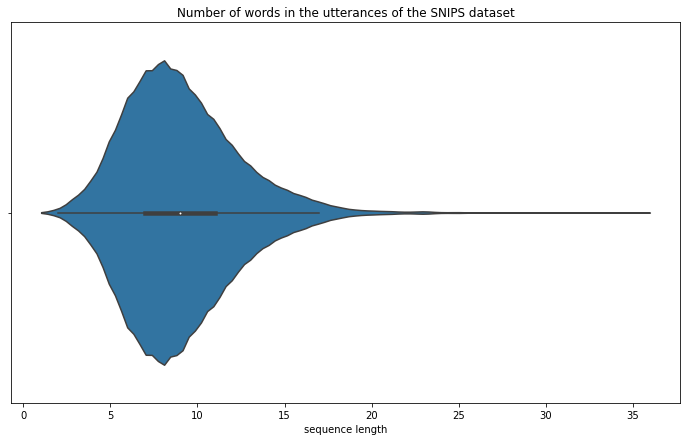

In [3]:
plt.figure(figsize=(12, 7))
chart = sns.violinplot(x=df.utterance.apply(len))
chart.set_xlabel("sequence length")
_ = chart.set_title(f"Number of words in the utterances of the {DATASET_NAME.upper()} dataset")

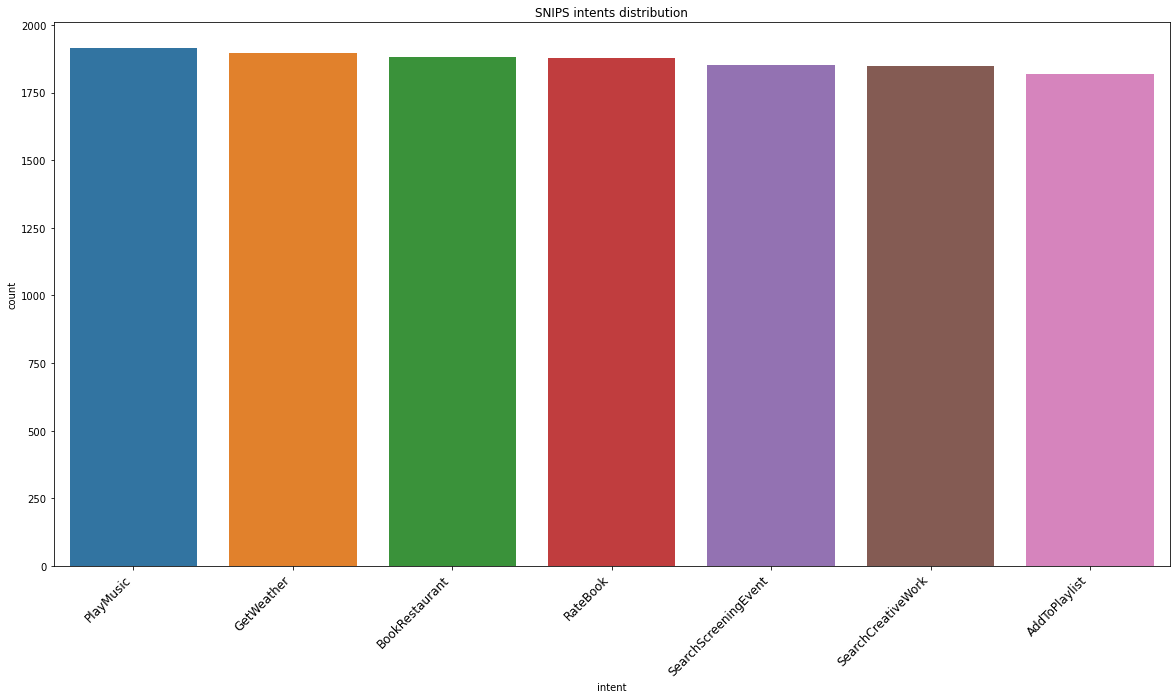

In [4]:
plt.figure(figsize=(20, 10))
chart = sns.countplot(data=df, x='intent', order=df.intent.value_counts().index)
chart.set_xticklabels(
    chart.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize='large'
)
_ = chart.set_title(f"{DATASET_NAME.upper()} intents distribution")

### Frequent & Rare Slots

In [5]:
lst_tags = df.slots.tolist()

all_tags = [tag for sent_tags in lst_tags for tag in sent_tags]
tags_count = Counter(all_tags)

print("5 Most Common Tags:\n", tags_count.most_common(5), "\n")
print("5 Least Common Tags:\n", tags_count.most_common()[:-6:-1], "\n")

5 Most Common Tags:
 [('O', 57288), ('I-object_name', 7482), ('I-playlist', 3239), ('B-object_type', 3023), ('B-object_name', 2789)] 

5 Least Common Tags:
 [('I-object_part_of_series_type', 2), ('I-object_select', 3), ('I-facility', 14), ('I-cuisine', 30), ('I-music_item', 36)] 



### Average number of words of each slot

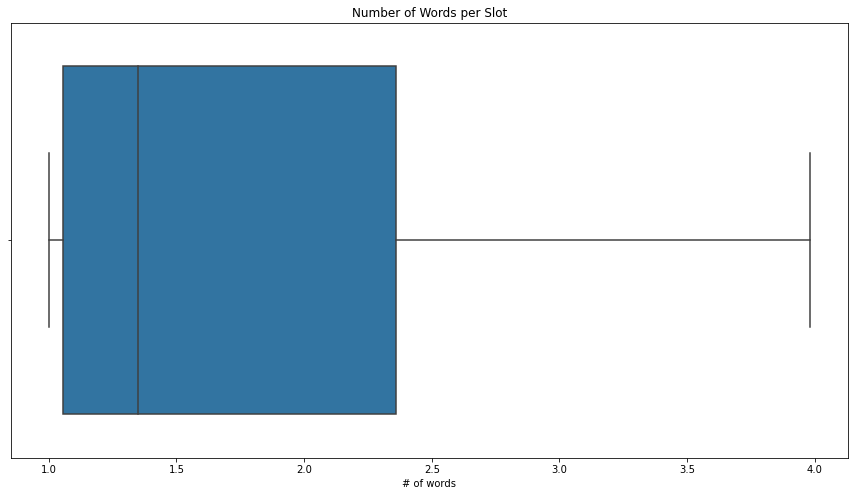

In [6]:
# Find the average number of words for each slot
tag_word_length = {}
for tag in tags_count.keys():
    if tag.startswith('B-'):
        begin_tag_count = tags_count[tag]
        try:
            inside_tag_count = tags_count[f"I-{tag[2:]}"]
        except KeyError:
            continue

        if inside_tag_count == 0:
            tag_word_length[tag[2:]] = 1
            continue

        tag_word_length[tag[2:]] = round(1 + inside_tag_count / begin_tag_count, 2)

# print("Average words per Slot Tag:")
# tag_word_length

plt.figure(figsize=(15, 8))

chart = sns.boxplot(x=list(tag_word_length.values()))
chart.set_xlabel("# of words")
_ = chart.set_title("Number of Words per Slot")

### Relevant Slots per Intent

(Intent) PlayMusic, (Relevant Slots): {'album', 'year', 'artist', 'playlist', 'track', 'sort', 'service', 'music_item', 'genre'}
(Intent) AddToPlaylist, (Relevant Slots): {'playlist_owner', 'artist', 'playlist', 'entity_name', 'music_item'}
(Intent) RateBook, (Relevant Slots): {'object_name', 'rating_unit', 'best_rating', 'rating_value', 'object_select', 'object_part_of_series_type', 'object_type'}
(Intent) SearchScreeningEvent, (Relevant Slots): {'spatial_relation', 'movie_type', 'timeRange', 'object_location_type', 'movie_name', 'object_type', 'location_name'}
(Intent) BookRestaurant, (Relevant Slots): {'restaurant_type', 'poi', 'spatial_relation', 'cuisine', 'country', 'sort', 'timeRange', 'party_size_description', 'party_size_number', 'facility', 'city', 'restaurant_name', 'served_dish', 'state'}
(Intent) GetWeather, (Relevant Slots): {'current_location', 'spatial_relation', 'condition_temperature', 'geographic_poi', 'country', 'timeRange', 'city', 'state', 'condition_description'}

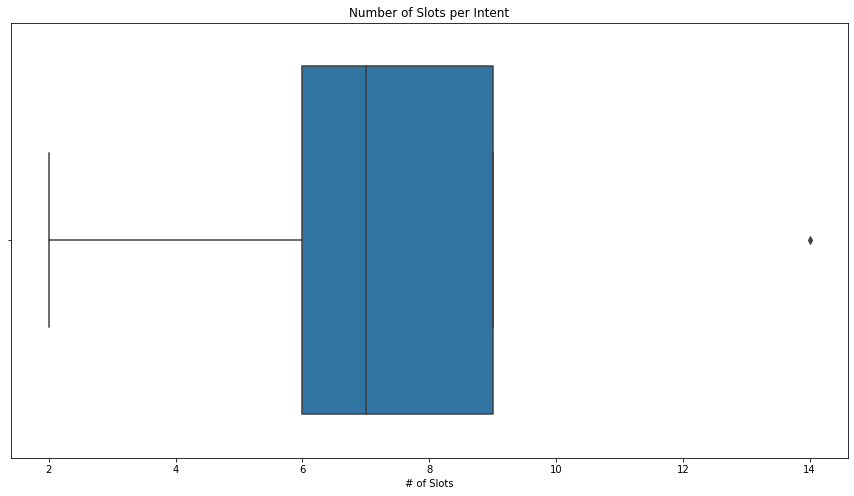

In [7]:
intent_slots_mapping = defaultdict(set)
_, slots, intents = reader.read_dataset(mode='train')
assert len(slots) == len(intents)
for tags, intent in zip(slots, intents):
    for tag in tags:
       if tag != 'O':
            intent_slots_mapping[intent].add(tag[2:])

rel_slots = []
for intent, slots in intent_slots_mapping.items():
    print(f"(Intent) {intent}, (Relevant Slots): {slots}")
    rel_slots.append([intent, len(slots)])

print()
intent_slots_mapping_df = pd.DataFrame(data=rel_slots, columns=['intent', 'n_slots'])
# intent_slots_mapping_df
plt.figure(figsize=(15, 8))

chart = sns.boxplot(x=intent_slots_mapping_df.n_slots)
chart.set_xlabel("# of Slots")
_ = chart.set_title("Number of Slots per Intent")

In [30]:
slot_set = set()
for slots in intent_slots_mapping.values():
    for slot in slots:
        slot_set.add(slot)

print(f"Number of unique slots of the dataset (excluding the Inside Tags!) = {len(slot_set)}")

Number of unique slots of the dataset (excluding the Inside Tags!) = 39


### Error Analysis

In [9]:
# firstly run `main.py` in order to create the csv file
df_test = pd.read_csv(f"{DATASET_NAME}_test_preds.csv")
df_test.head()

,Unnamed: 0,utterance,slots,intent,intent_pred,slots_preds
0,0,"['add', 'sabrina', 'salerno', 'to', 'the', 'gr...","['O', 'B-artist', 'I-artist', 'O', 'O', 'B-pla...",AddToPlaylist,AddToPlaylist,"['O', 'B-artist', 'I-artist', 'O', 'O', 'B-pla..."
1,1,"['i', 'want', 'to', 'bring', 'four', 'people',...","['O', 'O', 'O', 'O', 'B-party_size_number', 'O...",BookRestaurant,BookRestaurant,"['O', 'O', 'O', 'O', 'B-party_size_number', 'O..."
2,2,"['put', 'lindsey', 'cardinale', 'into', 'my', ...","['O', 'B-artist', 'I-artist', 'O', 'B-playlist...",AddToPlaylist,AddToPlaylist,"['O', 'B-artist', 'I-artist', 'O', 'B-playlist..."
3,3,"['will', 'it', 'snow', 'in', 'mt', 'on', 'june...","['O', 'O', 'B-condition_description', 'O', 'B-...",GetWeather,GetWeather,"['O', 'O', 'B-condition_description', 'O', 'B-..."
4,4,"['play', 'signe', 'anderson', 'chant', 'music'...","['O', 'B-artist', 'I-artist', 'B-music_item', ...",PlayMusic,PlayMusic,"['O', 'B-artist', 'I-artist', 'B-music_item', ..."


In [10]:
df_test["slots"] = df_test.slots.apply(eval)
# df_test["slots"]

In [11]:
reader = Reader(DATASET_NAME)
_, slots, intents = reader.read_dataset(mode='test')
slot_labels = reader.get_slot_labels()
intent_labels = reader.get_intent_labels()

# slot_not_found_counter = sum(1 for tag_lst in df_test.slots.tolist() for tag in tag_lst if tag not in slot_labels)
intent_not_found_counter = sum(1 for intent in intents if intent not in intent_labels)
slot_not_found_counter = sum(1 for tag_lst in slots for tag in tag_lst if tag not in slot_labels)
print(f"Number of test set slots that were not found in the training set: {slot_not_found_counter}\n"
      f"Number of test set intents that were not found in the training set {intent_not_found_counter}")


Number of test set slots that were not found in the training set: 0
Number of test set intents that were not found in the training set 0
